In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Read in the data
df = pd.read_excel('e-commerce-dataset.xlsx', sheet_name='E_Comm')
df.to_csv('e-commerce_churn.csv', index=False)
df = pd.read_csv('e-commerce_churn.csv')

In [3]:
print(df.info())
df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [4]:
df['Churn'] = df['Churn'].astype('category')

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns

# Apply one-hot encoding to non-numeric columns
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)

## Exercise T8.3 a)

Your colleague proposes to train the model on the entire dataset and argues to tune the n_estimators
and max_features parameters of sklearn.ensemble.RandomForestClassifier until the training
accuracy is maximized. Do you agree? If not, which issues can you identify with this approach?

What is the accuracy of your random forest model on the training dataset?


In [5]:
# Train a random forest model
train_model = RandomForestClassifier(n_estimators=5, max_features=3, random_state=2023+2024)

X = df.drop(columns=["Churn"])
y = df["Churn"]

train_model.fit(X,y)

# Calculate accuracy
pred = train_model.predict(X)
error_rate = np.mean(y != pred)
print("Error rate:", error_rate)
print("Accuracy:", accuracy_score(y, pred))

Error rate: 0.0042395336512983575
Accuracy: 0.9957604663487016


## Exercise T8.3 c)

Perform training, 4-fold cross-validation, and testing with a 60-20-20 % split in Python. Use the
precision as metric for model selection. Build a confusion matrix for the test set and report precision,
accuracy, and recall.

In [8]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df['Churn'], random_state=2023+2024)

# Check label balancing
print("Label Balancing in Train Set:\n", train_df['Churn'].value_counts(normalize=True))
print("Label Balancing in Test Set:\n", test_df['Churn'].value_counts(normalize=True))

# Define some Models
train_model_1 = RandomForestClassifier(n_estimators=5,
                                       max_features=3,
                                       random_state=2023+2024)

train_model_2 = RandomForestClassifier(n_estimators=8,
                                       max_features=3,
                                       random_state=2023+2024)

train_model_3 = RandomForestClassifier(n_estimators=5,
                                       max_features=10,
                                       random_state=2023+2024)

# Split features and labels
X = train_df.drop(columns=["Churn"])
y = train_df["Churn"]

# Perform cross-validation on all three models and choose the one with the highest
#  average precision (across all folds)
best_model = None
best_score = -1
for i, train_model in enumerate([train_model_1, train_model_2, train_model_3]):
    print("train_model_"+str(i+1)+":")
    score = np.mean(cross_val_score(train_model, X, y, cv=4, scoring="precision"))
    print("Average score across all folds:", score)
    if score >= best_score:
        best_score = score
        best_model = train_model


# Train the final model (no cross-validation)
print("\nbest_model:", best_model.n_estimators, best_model.max_features)
best_model.fit(X, y)

# Report scores on final model
y_pred = best_model.predict(X)
print("\nPrecision:", precision_score(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))

Label Balancing in Train Set:
 Churn
0    0.832726
1    0.167274
Name: proportion, dtype: float64
Label Balancing in Test Set:
 Churn
0    0.833113
1    0.166887
Name: proportion, dtype: float64
train_model_1:
Average score across all folds: 0.8242270101021969
train_model_2:
Average score across all folds: 0.891166832525193
train_model_3:
Average score across all folds: 0.8264881718559458

best_model: 8 3

Precision: 1.0
Accuracy: 0.9920503477972838
Recall: 0.9524752475247524


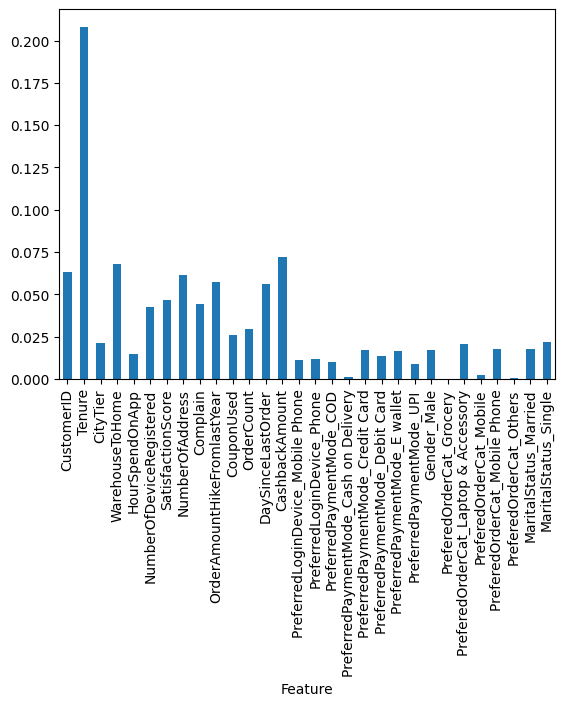

     Churn  Predicted_Churn  Probability_Churn=0  Probability_Churn=1
3272     0                0                1.000                0.000
5323     0                0                0.875                0.125
4126     0                0                0.875                0.125
1005     0                0                1.000                0.000
5180     0                0                0.875                0.125
...    ...              ...                  ...                  ...
1503     0                0                0.875                0.125
2367     0                0                1.000                0.000
271      0                0                1.000                0.000
2238     0                0                1.000                0.000
4296     1                1                0.375                0.625

[755 rows x 4 columns]


In [9]:
# Variable Importance Plot
importance_values = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

# Apply on test set
test_predictions = best_model.predict(test_df.drop(columns=['Churn']))
test_probabilities = best_model.predict_proba(test_df.drop(columns=['Churn']))

test_predictions_df = pd.DataFrame({'Churn': test_df['Churn'], 
                                     'Predicted_Churn': test_predictions,
                                     'Probability_Churn=0': test_probabilities[:, 0],
                                     'Probability_Churn=1': test_probabilities[:, 1]})

print(test_predictions_df)

In [13]:
# Confusion Matrix
`conf_matrix = confusion_matrix(test_df['Churn'], test_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("\nTest-Precision:", precision_score(test_df['Churn'], test_predictions))
print("Test-Accuracy:", accuracy_score(test_df['Churn'], test_predictions))
print("Test-Recall:", recall_score(test_df['Churn'], test_predictions))


Confusion Matrix:
[[626   3]
 [ 50  76]]

Test-Precision: 0.9620253164556962
Test-Accuracy: 0.9298013245033112
Test-Recall: 0.6031746031746031
